In [24]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt

from keras import applications
from efficientnet.tfkeras import EfficientNetB3
from keras import callbacks
from keras.models import Sequential
import cv2

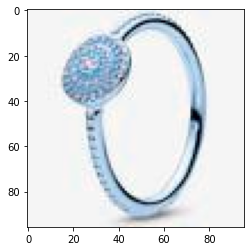

In [25]:
img = cv2.imread('data_small/train/150184CZ/150184CZ_00_OG.jpg')
plt.figure()
plt.imshow(img)

## Model

In [26]:
from keras.layers import Dense
from keras.optimizers import Adam

efficient_net = EfficientNetB3(
    weights='imagenet',
    input_shape=(32,32,3),
    include_top=False,
    pooling='max'
)

model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 120, activation='relu'))
model.add(Dense(units = 120, activation = 'relu'))
model.add(Dense(units = 1, activation='sigmoid'))
model.summary()

44113920/44107200 [==============================] - 10s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Functional) (None, 1536)              10783528  
_________________________________________________________________
dense (Dense)                (None, 120)               184440    
_________________________________________________________________
dense_1 (Dense)              (None, 120)               14520     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 121       
Total params: 10,982,609
Trainable params: 10,895,313
Non-trainable params: 87,296
_________________________________________________________________


In [27]:
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
history = model.fit(
    train_generator,
    epochs = 50,
    steps_per_epoch = 15,
    validation_data = val_generator,
    validation_steps = 7
)

NameError: name 'train_generator' is not defined

In [169]:
import json
def dict_from_json(path):
    # open the product catalog:
    a_file = open(path, "r")
    catalog = json.loads(a_file.read())
    a_file.close()
    return catalog
categories = dict_from_json('./catalog_by_category.json')

In [205]:
filenames = []
walk = os.walk("data_small/train")
for root, dirs, files in walk:
    for file in files:
        if ".jpg" in file and "checkpoint.jpg" not in file:
            filenames.append(os.path.join(root, file))

N = len(filenames)

In [206]:
d = 'data_small/train'
folders = [os.path.join(d, o)[len(d)+1:] for o in os.listdir(d) 
                    if os.path.isdir(os.path.join(d,o))]

In [207]:
N

4035

In [208]:
labels = []
for folder in folders:
    for key, val in categories.items():
        if folder in val:
            labels.append([key]*len(os.listdir(d+'/'+folder)))
flat_labels = [item for sublist in labels for item in sublist]
            
labels = np.array(flat_labels)
len(labels)

4038

In [155]:
d = 'data_small/train/' + folders[-1]
[os.path.join(d, o) for o in os.listdir(d) 
                    if os.path.isdir(os.path.join(d,o))]

[]

In [158]:
len(os.listdir(d))

40

In [131]:
for a, b in categories.items():
    print(a)
    for j in b:
        print(j)


Bracelets
589338C00
589358C01
599343C00
599347C00
599338C00
599292C01
599297C01
599299C01
599285C00
589287C01
599288C01
599223C01
599166C01
589217C01
599190C01
599217C02
599217C01
599206C00
589177C01
599254C00
599082C00
589087C00
589046C01
569046C01
599046C01
588145C01
599377C02
598827C01
598893C00
598911C00
588781C00
598776C01
588782C00
587749C00
598699C01
598698C00
598619C00
598498C01
598432C01
588508C01
598528C01
598510C01
599377C01
598373
598406C00
598408C00
598286CZ
588342CZ
588333CZ
598276CZ
598538C01_P1
588143
598047CCZ
588059CBK
597776CZ
598100
588093NCCMX
597943
597953CZ
597791
567804
597749
597558CZ
587712
597712
586477
589375C01
586543
597225CBK
587125CZ
587132
597125CZ
568748C00
597092CZ
586292CZ
596543
596268
580728
596477
590743CZ
550713
599375C01
590741CZ_P1
590731CZ
590728
590727CZ
590723CZ
580702
590719
596002
590713
550702
590702HV
598807C01
598816C00
598400C00
587953CZ
597837CZ
560719
597770CZ
567712
567110CZ
567107
580719
580713
590741CZ
599103C00
598342CZ
568707C00

In [55]:
filenames[0]

'data_small/train\\150184CZ\\150184CZ_00_OG.jpg'

In [71]:
'589338C00' in categories.values()

False

['Rings']